In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [33]:
import pandas as pd
import os

In [34]:
os.chdir("/kaggle/input/aid-scene-classification-datasets/AID")
os.getcwd()

'/kaggle/input/aid-scene-classification-datasets/AID'

In [35]:
dirr="/kaggle/input/aid-scene-classification-datasets/AID"

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
pip install split-folders


Note: you may need to restart the kernel to use updated packages.


In [38]:
import splitfolders

# Input directory (where your dataset is located)
input_dir = '/kaggle/input/aid-scene-classification-datasets/AID'

# Output directory (where the split folders will be saved)
output_dir = '/kaggle/working/split_data'

# Split the dataset into train (70%), val (20%), and test (10%)
splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=(0.7, 0.2, 0.1), group_prefix=None)

print("Dataset split completed!")


Copying files: 10000 files [00:24, 407.39 files/s]

Dataset split completed!


In [94]:
train_datagen=ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    channel_shift_range=30.0
    
)
test_datagen=ImageDataGenerator(
    rescale=1.0/255,
    
)
val_datagen=ImageDataGenerator(
    rescale=1.0/255,

)

In [95]:
train=train_datagen.flow_from_directory(
    "/kaggle/working/split_data/train",
    batch_size=32,
    target_size=(256,256),
    class_mode="sparse",
  
)
test=train_datagen.flow_from_directory(
    "/kaggle/working/split_data/test",
    batch_size=32,
    target_size=(256,256),
    class_mode="sparse",
)
val=train_datagen.flow_from_directory(
    "/kaggle/working/split_data/val",
    batch_size=32,
    target_size=(256,256),
    class_mode="sparse",
)

Found 6993 images belonging to 30 classes.
Found 1007 images belonging to 30 classes.
Found 2000 images belonging to 30 classes.


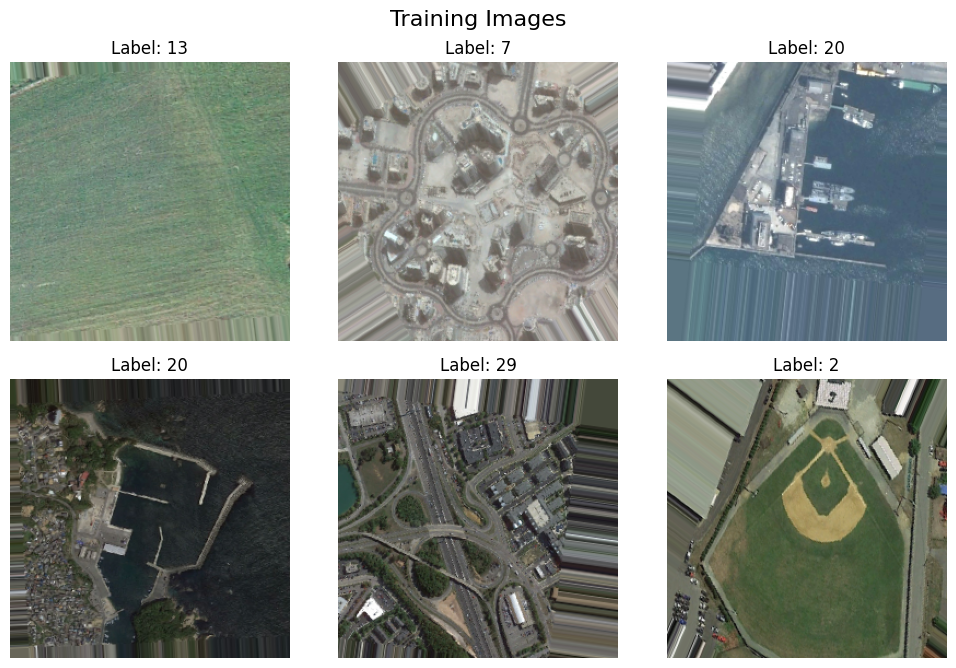

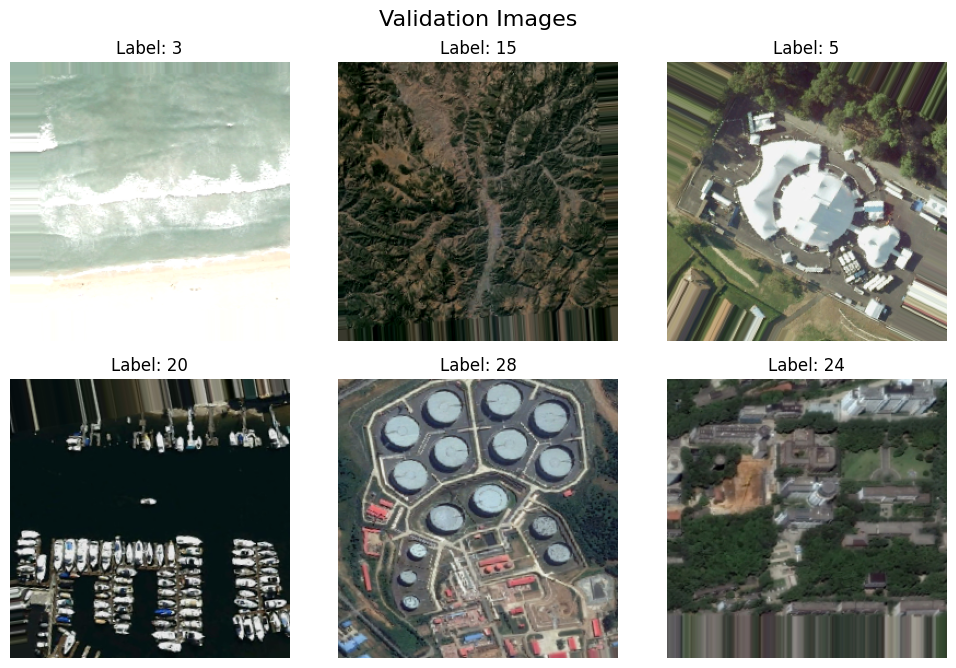

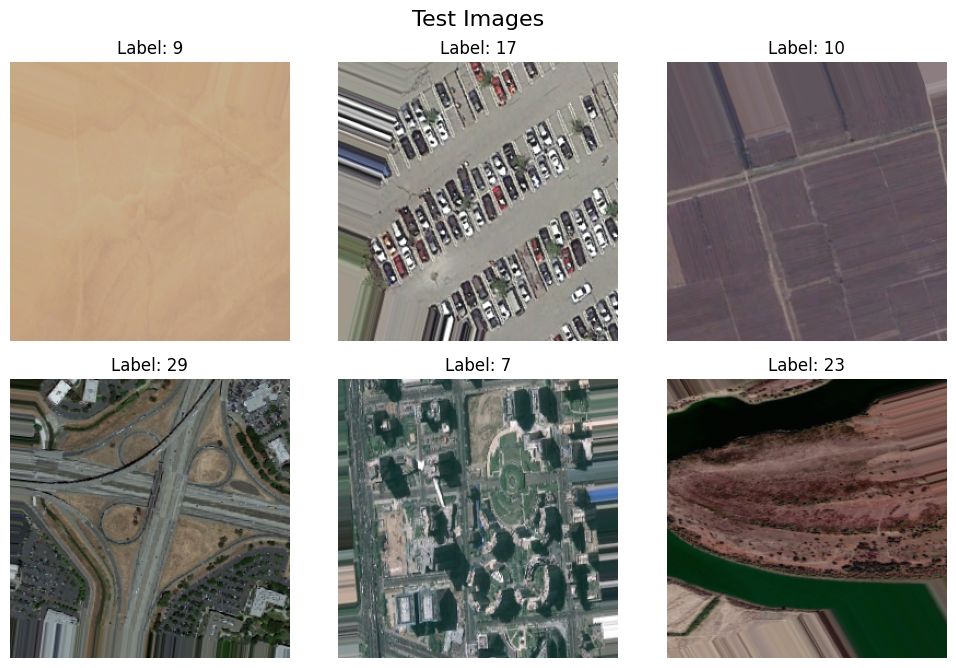

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot 6 images in a 3x3 grid
def plot_images(generator, title):
    images, labels = next(generator)  # Get one batch of data
    plt.figure(figsize=(10, 10))
    for i in range(6):  # Plot 6 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot training images
plot_images(train, "Training Images")

# Plot validation images
plot_images(val, "Validation Images")

# Plot test images
plot_images(test, "Test Images")


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Dropout,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256,256, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 8, 8, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,217,921 (16.09 MB)

 Trainable params: 4,175,642 (15.93 MB)

 Non-trainable params: 42,279 (165.16 KB)

In [13]:
early_stopping=EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [14]:
history=model.fit(
    train,
    validation_data=val,
    epochs=250,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 196s 779ms/step - accuracy: 0.5173 - loss: 1.8519 - val_accuracy: 0.0300 - val_loss: 8.9520
Epoch 2/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 171s 763ms/step - accuracy: 0.8618 - loss: 0.4891 - val_accuracy: 0.0640 - val_loss: 7.6582
Epoch 3/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 169s 755ms/step - accuracy: 0.8944 - loss: 0.3549 - val_accuracy: 0.6925 - val_loss: 1.1242
Epoch 4/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 170s 756ms/step - accuracy: 0.8968 - loss: 0.3611 - val_accuracy: 0.8805 - val_loss: 0.4336
Epoch 5/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 170s 755ms/step - accuracy: 0.9155 - loss: 0.2930 - val_accuracy: 0.9120 - val_loss: 0.3147
Epoch 6/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 169s 752ms/step - accuracy: 0.9266 - loss: 0.2447 - val_accuracy: 0.8435 - val_loss: 0.5676
Epoch 7/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 168s 750ms/step - accuracy: 0.9414 - loss: 0.2075 - val_accuracy: 0.9130 - val_loss: 0.3019
Epoch 8/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 168s 746ms/step - accuracy: 

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 574ms/step - accuracy: 0.9187 - loss: 0.3218
Test Loss: 0.34110283851623535
Test Accuracy: 0.9096325635910034


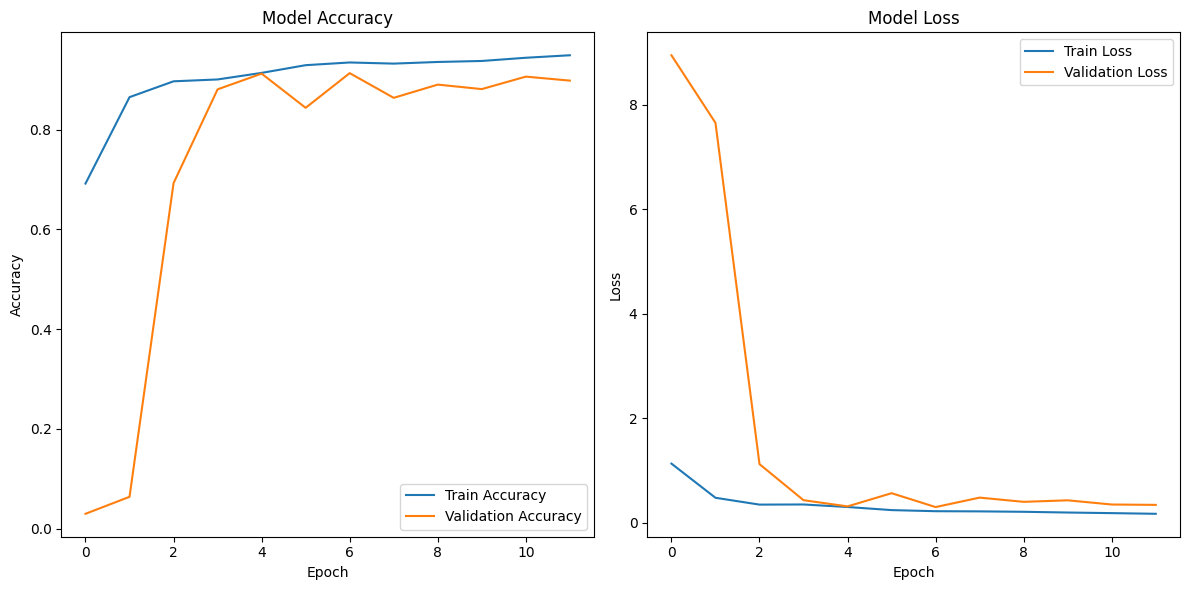

In [18]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 574ms/step


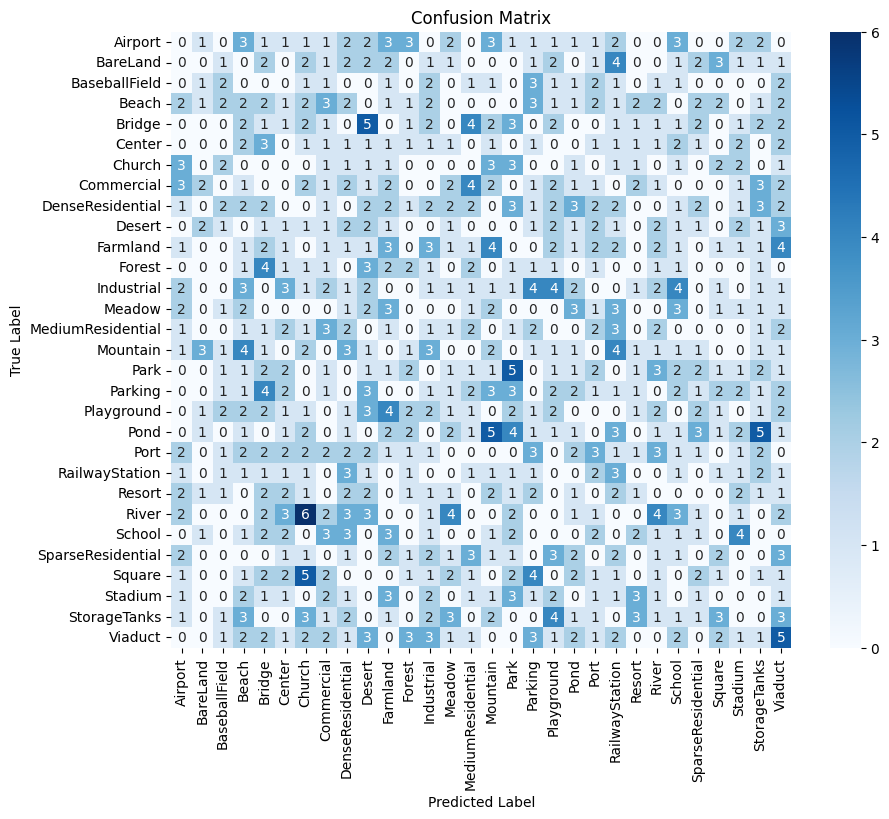

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the test data
y_pred = model.predict(test, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Get the true labels from the test generator
y_true = test.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetB7, EfficientNetV2L


In [65]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization, Input
from tensorflow.keras.applications import InceptionV3, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

# Use a distributed training strategy
strategy = tf.distribute.MirroredStrategy()

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

with strategy.scope():
    inputs = Input(shape=(256, 256, 3))  # Corrected input size

    # InceptionV3 model (base feature extractor)
    inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))(inputs)
    inception_v3 = GlobalAveragePooling2D()(inception_v3)
    inception_v3 = BatchNormalization()(inception_v3)
    inception_v3 = Dropout(0.3)(inception_v3)

    # EfficientNetB0 model (base feature extractor)
    efficientnet_b0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))(inputs)
    efficientnet_b0 = GlobalAveragePooling2D()(efficientnet_b0)
    efficientnet_b0 = BatchNormalization()(efficientnet_b0)
    efficientnet_b0 = Dropout(0.3)(efficientnet_b0)

    # Combine the outputs of both models
    x = Concatenate()([inception_v3, efficientnet_b0])

    # First dense layer with more neurons
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)  # Batch Normalization to stabilize the learning
    x = Dropout(0.4)(x)

    # Add more dense layers to increase complexity
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second dense layer for final classification
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)

    # Final output layer with softmax activation for classification (30 classes)
    outputs = Dense(30, activation='softmax')(x)

    # Create the model
    model = Model(inputs, outputs)

    # Optimizer
    optimizer = Adam(learning_rate=0.001)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Print the model summary
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 6, 6, 2048)     │     21,802,784 │ input_layer_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 8, 8, 1280)     │      4,049,571 │ input_layer_32[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_612   │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_613   │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (None, 2048)           │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_58 (Dropout)      │ (None, 1280)           │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_21            │ (None, 3328)           │              0 │ dropout_57[0][0],      │
│ (Concatenate)             │                        │                │ dropout_58[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 512)            │      1,704,448 │ concatenate_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_614   │ (None, 512)            │          2,048 │ dense_47[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_59 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 256)            │        131,328 │ dropout_59[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_615   │ (None, 256)            │          1,024 │ dense_48[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 27,748,129 (105.85 MB)

 Trainable params: 27,663,226 (105.53 MB)

 Non-trainable params: 84,903 (331.66 KB)

In [66]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)


In [26]:
# Print the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb7            │ (None, 8, 8, 2560)     │     64,097,687 │ input_layer_5[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetv2-l          │ (None, 8, 8, 1280)     │    117,746,848 │ input_layer_5[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2560)           │              0 │ efficientnetb7[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetv2-l[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2560)           │         10,240 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 1280)           │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2560)           │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1280)           │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3840)           │              0 │ dropout_3[0][0],       │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │      1,966,592 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 512)            │          2,048 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 256)            │          1,024 │ dense_3[0][0]          │
│ (BatchNormalization) 

 Total params: 184,004,501 (701.92 MB)

 Trainable params: 183,171,726 (698.74 MB)

 Non-trainable params: 832,775 (3.18 MB)

In [68]:
# Training the model with callbacks
history = model.fit(
    train,
    epochs=55,
    validation_data=val,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/55
219/219 ━━━━━━━━━━━━━━━━━━━━ 247s 880ms/step - accuracy: 0.1026 - loss: 17.1589 - val_accuracy: 0.0525 - val_loss: 19.5296 - learning_rate: 0.0010
Epoch 2/55
219/219 ━━━━━━━━━━━━━━━━━━━━ 192s 857ms/step - accuracy: 0.5461 - loss: 7.4037 - val_accuracy: 0.0485 - val_loss: 7.0816 - learning_rate: 0.0010
Epoch 3/55
219/219 ━━━━━━━━━━━━━━━━━━━━ 192s 855ms/step - accuracy: 0.7131 - loss: 3.6209 - val_accuracy: 0.1920 - val_loss: 9.1685 - learning_rate: 0.0010
Epoch 4/55
219/219 ━━━━━━━━━━━━━━━━━━━━ 191s 852ms/step - accuracy: 0.7626 - loss: 2.4301 - val_accuracy: 0.4195 - val_loss: 8.6208 - learning_rate: 0.0010
Epoch 5/55
219/219 ━━━━━━━━━━━━━━━━━━━━ 190s 849ms/step - accuracy: 0.7839 - loss: 1.9851 - val_accuracy: 0.4070 - val_loss: 7.7397 - learning_rate: 0.0010
Epoch 6/55
219/219 ━━━━━━━━━━━━━━━━━━━━ 191s 852ms/step - accuracy: 0.8384 - loss: 1.5363 - val_accuracy: 0.7815 - val_loss: 2.8786 - learning_rate: 5.0000e-04
Epoch 7/55
219/219 ━━━━━━━━━━━━━━━━━━━━ 190s 847ms/step - 

In [98]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 566ms/step - accuracy: 0.9747 - loss: 0.2198
Test Loss: 0.2534746527671814
Test Accuracy: 0.968222439289093


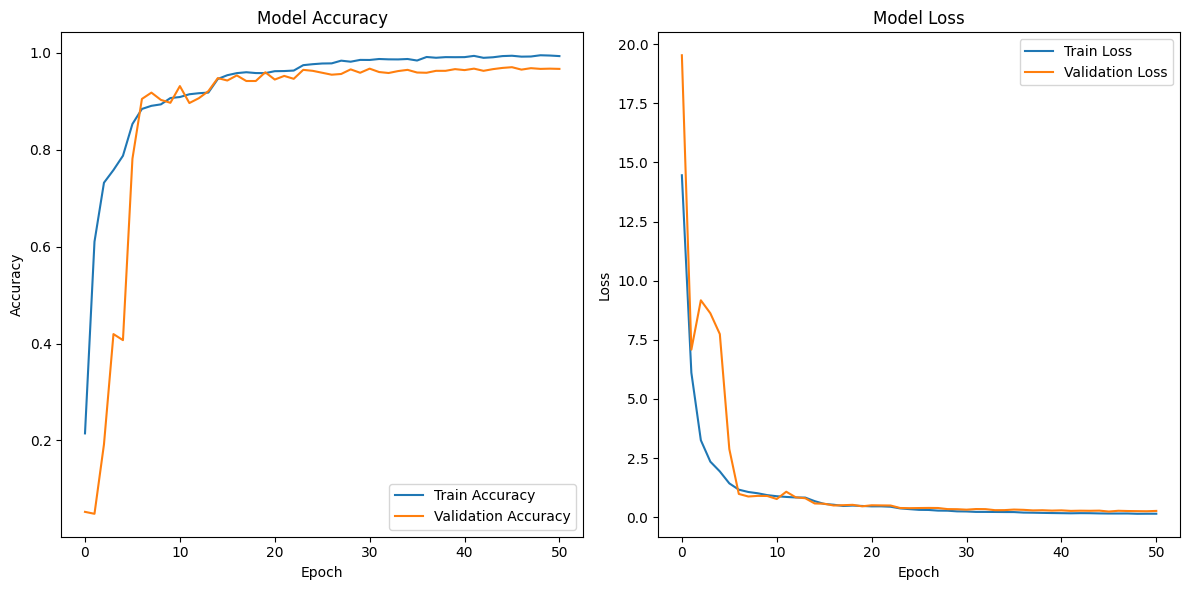

In [99]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


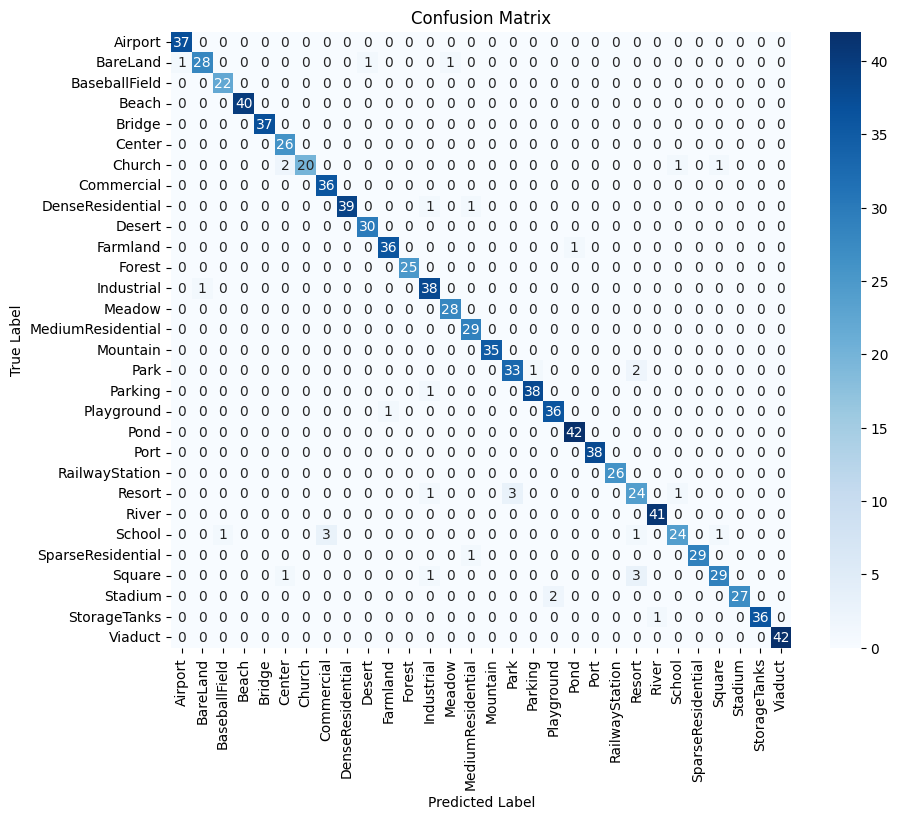

In [100]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the test directory
test_dir = '/kaggle/working/split_data/test'

# Class mapping
class_indices = train.class_indices  # Assuming you have the class_indices from training
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping (index to class name)

# Helper function to preprocess images
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(256, 256))  # Resize image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

# Load test images and true labels
y_true = []
y_pred = []
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img_array = preprocess_image(img_path)  # Preprocess the image
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict the class
            prediction = model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction)

            # Append the true and predicted labels
            y_true.append(class_indices[class_name])  # True label as index
            y_pred.append(predicted_class)  # Predicted label as index

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=classes.values(),
    yticklabels=classes.values()
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


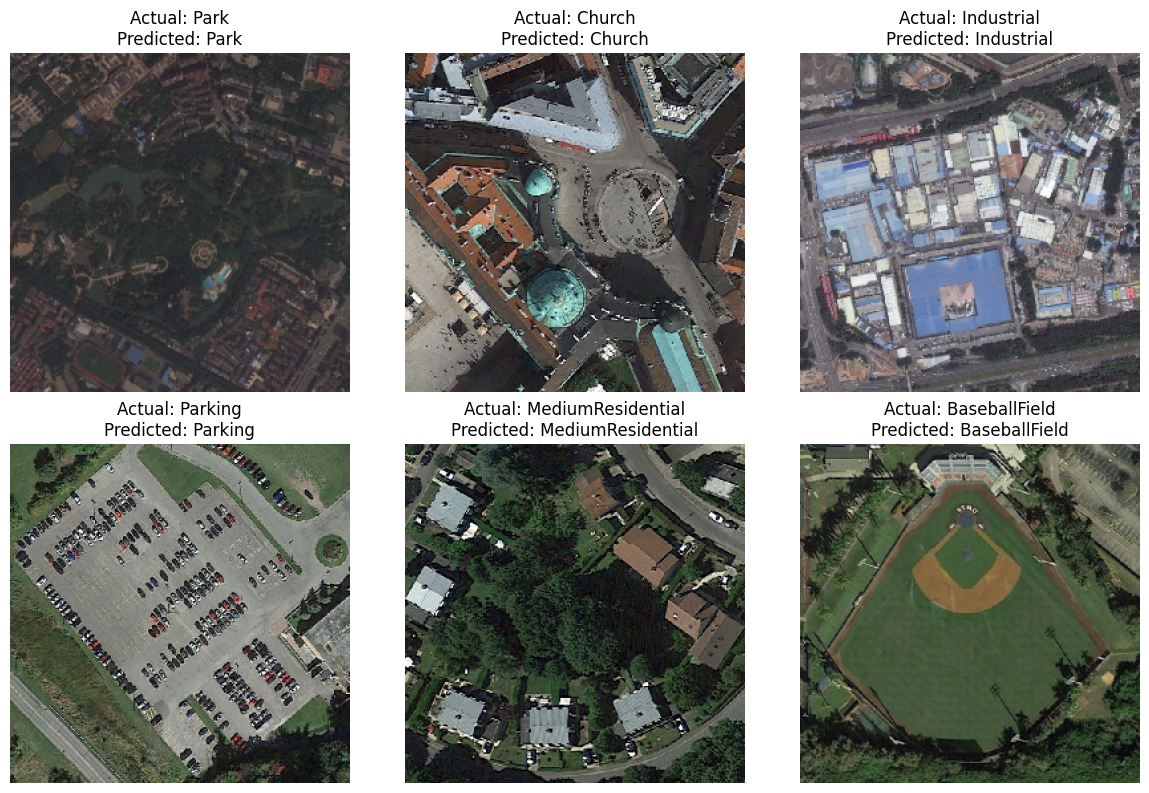

In [106]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the test directory
test_dir = '/kaggle/working/split_data/test'

# Class mapping (same as before)
class_indices = train.class_indices  # Assuming class_indices is from training
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping (index to class name)

# Helper function to preprocess images
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(256, 256))  # Resize image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

# Select 6 random images from the test dataset
random_images = []
random_labels = []
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        image_files = os.listdir(class_dir)
        random_files = random.sample(image_files, 1)  # Select one random image per class
        for img_name in random_files:
            img_path = os.path.join(class_dir, img_name)
            random_images.append(img_path)
            random_labels.append(class_indices[class_name])

# Predict the class for each random image
predicted_labels = []
for img_path in random_images:
    img_array = preprocess_image(img_path)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    predicted_labels.append(predicted_class)

# Display the images along with actual and predicted labels
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = load_img(random_images[i], target_size=(256, 256))
    plt.imshow(img)
    actual_label = classes[random_labels[i]]
    predicted_label = classes[predicted_labels[i]]
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
